## CS818 Assessment: notebook 3
I am now ready to begin the unsupervised analysis part of the assessment

In [74]:
# Import required packages for project
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Load data
df = pd.read_csv("ObesityDataSet_raw_and_data_sinthetic.csv")

# Set up matplotlib integration 
%matplotlib inline

# Assess data
print(df.describe())

               Age       Height       Weight         FCVC          NCP  \
count  2111.000000  2111.000000  2111.000000  2111.000000  2111.000000   
mean     24.312600     1.701677    86.586058     2.419043     2.685628   
std       6.345968     0.093305    26.191172     0.533927     0.778039   
min      14.000000     1.450000    39.000000     1.000000     1.000000   
25%      19.947192     1.630000    65.473343     2.000000     2.658738   
50%      22.777890     1.700499    83.000000     2.385502     3.000000   
75%      26.000000     1.768464   107.430682     3.000000     3.000000   
max      61.000000     1.980000   173.000000     3.000000     4.000000   

              CH2O          FAF          TUE  
count  2111.000000  2111.000000  2111.000000  
mean      2.008011     1.010298     0.657866  
std       0.612953     0.850592     0.608927  
min       1.000000     0.000000     0.000000  
25%       1.584812     0.124505     0.000000  
50%       2.000000     1.000000     0.625350  
75% 

First in the data preprocessing stage is to establish if scaling is needed

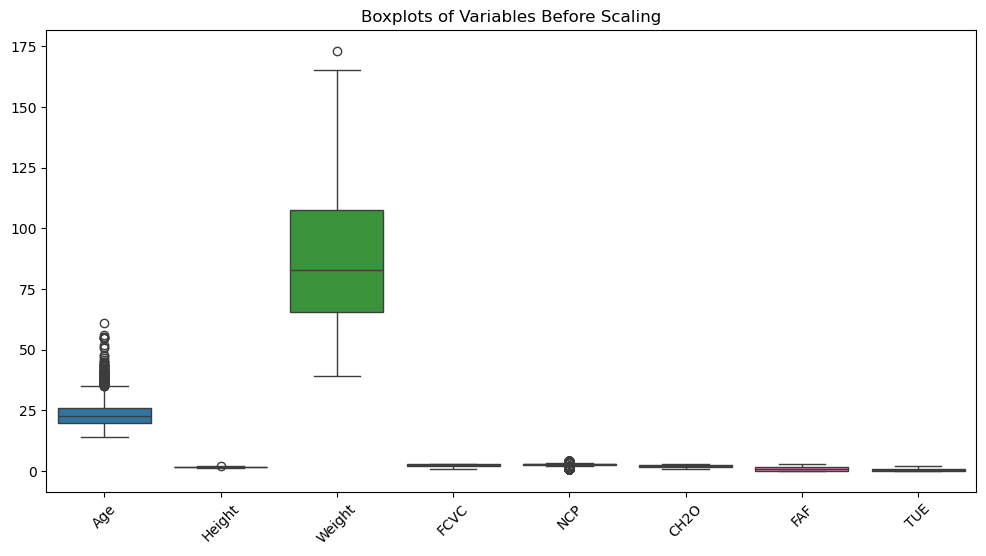

In [75]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.xticks(rotation=45)
plt.title("Boxplots of Variables Before Scaling")
plt.savefig("boxplots_prescale.pdf")
plt.show()

There is significant variability in the numerical variables with regard their spread, with weight running from 39 to 173, heigh from 14 to 61, and height from 1.45 to 1.98. To prevent the larger scales such as weight and height from dominating the clustering process, we need to scale the data. I also need to encode non-numerical variables so that they are amenable to cluster analysis. 

In [86]:
# Create a copy of the dataframe
df_cluster = df.copy()

# Encode the nominal categories
df_cluster = pd.get_dummies(df_cluster, columns=['MTRANS', 'NObeyesdad'], drop_first=True)

# Encode the binary columns (gender is categorical but only has two options in the dataset)
binary_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
binary_cols += [col for col in df_cluster.columns if col.startswith("MTRANS") or col.startswith("NObeyesdad")]

for col in binary_cols:
    df_cluster[col] = df_cluster[col].replace({'True': 1, 'False': 0, 'yes': 1, 'no': 0, 'Female': 0, 'Male':1}).astype(int).infer_objects(copy=False)
    df_cluster[col] = pd.to_numeric(df_cluster[col])

# Mapping ordinal categories to numeric values and then encoding
consumption_mapping = {'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3}
df_cluster['CAEC'] = df_cluster['CAEC'].map(consumption_mapping).astype(int)
df_cluster['CALC'] = df_cluster['CALC'].map(consumption_mapping).astype(int)

# Now I can use StandardScaler to scale the numerical columns
scaler = StandardScaler()
numerical_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
df_cluster[numerical_cols] = scaler.fit_transform(df[numerical_cols])

print(df_cluster.head())

   Gender       Age    Height    Weight  family_history_with_overweight  FAVC  \
0       0 -0.522124 -0.875589 -0.862558                               1     0   
1       0 -0.522124 -1.947599 -1.168077                               1     0   
2       1 -0.206889  1.054029 -0.366090                               1     0   
3       1  0.423582  1.054029  0.015808                               0     0   
4       1 -0.364507  0.839627  0.122740                               0     0   

       FCVC       NCP  CAEC  SMOKE  ...  MTRANS_Bike  MTRANS_Motorbike  \
0 -0.785019  0.404153     1      0  ...            0                 0   
1  1.088342  0.404153     1      1  ...            0                 0   
2 -0.785019  0.404153     1      0  ...            0                 0   
3  1.088342  0.404153     1      0  ...            0                 0   
4 -0.785019 -2.167023     1      0  ...            0                 0   

   MTRANS_Public_Transportation  MTRANS_Walking  NObeyesdad_Normal_W

/tmp/ipykernel_598103/3672559309.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cluster[col] = df_cluster[col].replace({'True': 1, 'False': 0, 'yes': 1, 'no': 0, 'Female': 0, 'Male':1}).astype(int).infer_objects(copy=False)
/tmp/ipykernel_598103/3672559309.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cluster[col] = df_cluster[col].replace({'True': 1, 'False': 0, 'yes': 1, 'no': 0, 'Female': 0, 'Male':1}).astype(int).infer_objects(copy=False)
/tmp/ipykernel_598103/3672559309.py:12: FutureWarning: Downcasting beh

In [87]:
df_cluster.describe()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,NObeyesdad_Normal_Weight,NObeyesdad_Obesity_Type_I,NObeyesdad_Obesity_Type_II,NObeyesdad_Obesity_Type_III,NObeyesdad_Overweight_Level_I,NObeyesdad_Overweight_Level_II
count,2111.000000,2111.000000,2.111000e+03,2.111000e+03,2111.000000,2111.000000,2.111000e+03,2.111000e+03,2111.000000,2111.000000,...,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,0.505921,0.000000,-5.385449e-16,-5.385449e-16,0.817622,0.883941,-1.346362e-17,4.964711e-16,1.140692,0.020843,...,0.003316,0.005211,0.748460,0.026528,0.135955,0.166272,0.140692,0.153482,0.137376,0.137376
std,0.500083,1.000237,1.000237e+00,1.000237e+00,0.386247,0.320371,1.000237e+00,1.000237e+00,0.468543,0.142893,...,0.057502,0.072015,0.434001,0.160737,0.342821,0.372413,0.347786,0.360537,0.344325,0.344325
min,0.000000,-1.625448,-2.698006e+00,-1.817304e+00,0.000000,0.000000,-2.658379e+00,-2.167023e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-0.688066,-7.683883e-01,-8.062914e-01,1.000000,1.000000,-7.850187e-01,-3.456952e-02,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,-0.241897,-1.263207e-02,-1.369510e-01,1.000000,1.000000,-6.283450e-02,4.041527e-01,1.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.265964,7.159595e-01,7.960531e-01,1.000000,1.000000,1.088342e+00,4.041527e-01,1.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,5.782584,2.983646e+00,3.300136e+00,1.000000,1.000000,1.088342e+00,1.689740e+00,3.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The data is now ready to process. Given that there is a large number of variables, and given the strong correlation between some of them (i.e. height, weight, obesity rate) it will also be appropriate to use PCA to reduce the dimensionality of the data

In [88]:
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_reduced = pca.fit_transform(df_cluster)

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_reduced)
labels = kmeans.labels_

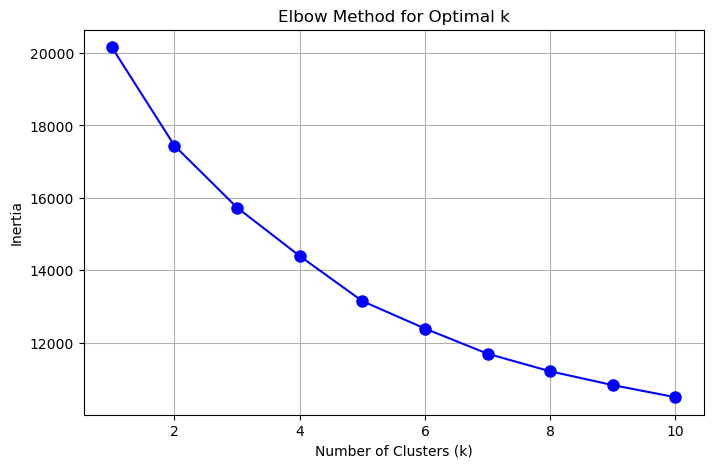

In [89]:
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_reduced)
    inertia.append(kmeans.inertia_)

# Plot Elbow
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, 'bo-', markersize=8)
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.savefig("elbow.pdf")
plt.show()

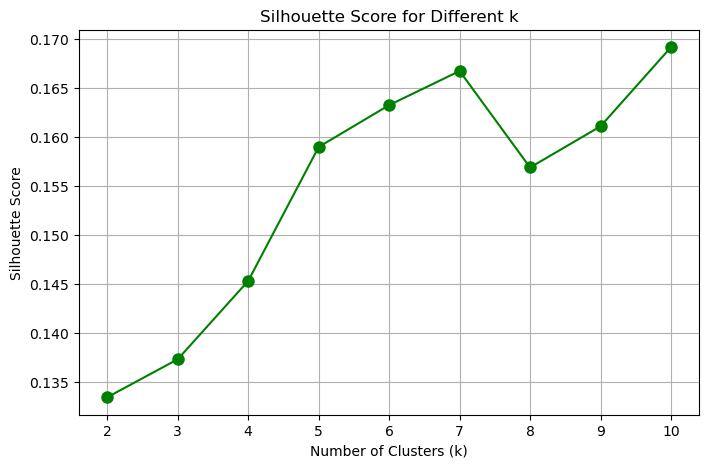

In [90]:
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_reduced)
    score = silhouette_score(X_reduced, labels)
    silhouette_scores.append(score)

# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, 'go-', markersize=8)
plt.title('Silhouette Score for Different k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.savefig("silhouette.pdf")
plt.show()

I have re-run the above analysis several times, and 4 is consistently the clearest candidate for number of clusters. I will therefore run the analysis with k=4

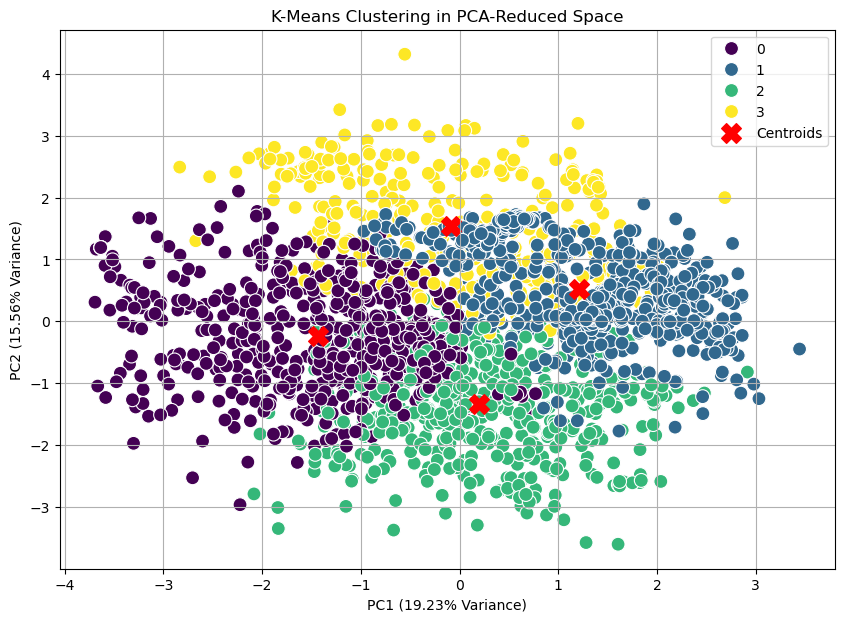

In [91]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_reduced)
labels = kmeans.labels_

# Add cluster labels to the data
df_cluster['Cluster'] = labels

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=labels, palette='viridis', s=100)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            s=200, c='red', marker='X', label='Centroids')
plt.title('K-Means Clustering in PCA-Reduced Space')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)')
plt.legend()
plt.grid(True)
plt.savefig("kmeans_pca_reduced.pdf")
plt.show()

I can now dig a bit more into the cluster and the defining features

In [92]:
cluster_profile = df_cluster.groupby('Cluster').mean()
print(cluster_profile)

           Gender       Age    Height    Weight  \
Cluster                                           
0        0.385260 -0.515212 -0.689830 -0.645192   
1        0.490625  0.017776  0.469548  1.146049   
2        0.631776 -0.586009  0.285400 -0.655171   
3        0.548673  1.798583 -0.122039  0.006561   

         family_history_with_overweight      FAVC      FCVC       NCP  \
Cluster                                                                 
0                              0.658291  0.832496 -0.323156 -0.770825   
1                              0.993750  0.987500  0.473510  0.332929   
2                              0.714019  0.798131 -0.126686  0.591462   
3                              0.929204  0.914454 -0.124912 -0.204496   

             CAEC     SMOKE  ...  MTRANS_Bike  MTRANS_Motorbike  \
Cluster                      ...                                  
0        1.180905  0.016750  ...     0.000000          0.008375   
1        1.020312  0.021875  ...     0.000000        

I'm interested to better understand how some of the demographic and lifestyle factors appear in the clusters:

In [67]:
# Exclude 'Height', 'Weight', and Obesity Category columns from cluster_profile
exclude_columns = ['Height', 'Weight'] + [col for col in cluster_profile.columns if col.startswith('NObeyesdad')]
cluster_profile_excluded = cluster_profile.drop(columns=exclude_columns)

# Identify top 5 strongest relationships for each cluster
top_relationships = {}
for idx, row in cluster_profile_excluded.iterrows():
    top_5 = row.abs().sort_values(ascending=False).head(5)  # Select top 5 by absolute value
    top_relationships[f'Cluster {idx}'] = top_5.index.tolist()

summary_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in top_relationships.items()]))
print(summary_df)

                        Cluster 0                       Cluster 1  \
0                            CAEC                            CAEC   
1    MTRANS_Public_Transportation  family_history_with_overweight   
2                            FAVC                            FAVC   
3                             NCP                            CALC   
4  family_history_with_overweight    MTRANS_Public_Transportation   

                        Cluster 2                       Cluster 3  
0                            CAEC                             Age  
1                             FAF                            CAEC  
2                            FAVC  family_history_with_overweight  
3    MTRANS_Public_Transportation                            FAVC  
4  family_history_with_overweight                            CALC  


And now to establish and visualise obesity distribution across clusters

         NObeyesdad_Normal_Weight  NObeyesdad_Obesity_Type_I  \
Cluster                                                        
0                             131                        122   
1                               1                         76   
2                             136                         57   
3                              19                         96   

         NObeyesdad_Obesity_Type_II  NObeyesdad_Obesity_Type_III  \
Cluster                                                            
0                                28                            3   
1                               201                          321   
2                                 2                            0   
3                                66                            0   

         NObeyesdad_Overweight_Level_I  NObeyesdad_Overweight_Level_II  
Cluster                                                                 
0                                  117                      

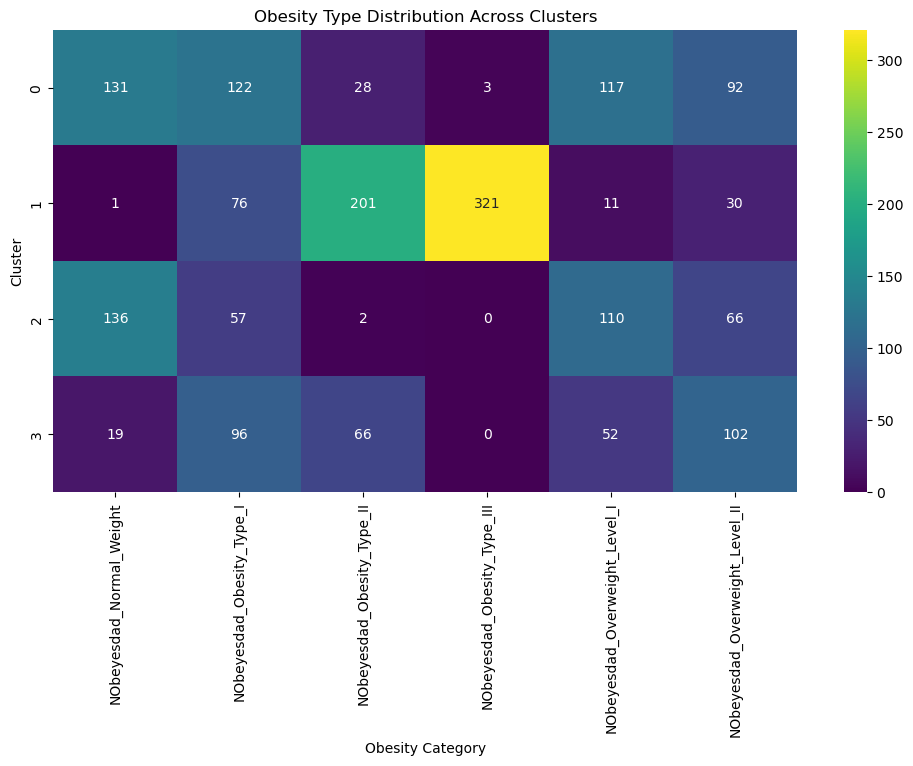

In [68]:
# List of Obesity Category Columns
obesity_columns = [
    'NObeyesdad_Normal_Weight', 'NObeyesdad_Obesity_Type_I', 'NObeyesdad_Obesity_Type_II',
    'NObeyesdad_Obesity_Type_III', 'NObeyesdad_Overweight_Level_I', 'NObeyesdad_Overweight_Level_II'
]

# Sum the occurrences of each obesity type within each cluster
cluster_obesity_dist = df_cluster.groupby('Cluster')[obesity_columns].sum()

# Display the table
print(cluster_obesity_dist)

# Plot the cross-tabulation as a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_obesity_dist, annot=True, cmap='viridis', fmt='.0f')
plt.title('Obesity Type Distribution Across Clusters')
plt.xlabel('Obesity Category')
plt.ylabel('Cluster')
plt.savefig("obesity_clusters.pdf")
plt.show()

Finally, I will store the dataset so I can use it in the final notebook too. 

In [70]:
df_cluster.to_csv('df_cluster.csv', index=False)